## Predictive modeling of future customer demand trends

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [2]:
df = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MBAinfo_Retail_Clean_update.xlsx'
df = pd.read_excel(df)

df.head()

,Material,Year/Period,Retail_sales
0,110,2020-04-01,183175
1,111,2020-04-01,243
2,112,2020-04-01,2096
3,113,2020-04-01,1673
4,120,2020-04-01,178781


In [3]:
jdf = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MARA_Clean.xlsx'
jdf = pd.read_excel(jdf)

jdf = jdf[['Material','Material Group']]
jdf.head()

,Material,Material Group
0,1,TRAINING
1,110,MISC_FA
2,112,MISC_FA
3,113,MISC_FA
4,120,MISC_FA


In [4]:
# perform left join on the 'Material' column
left_join = pd.merge(df, jdf, on='Material', how='left')
left_join.head()

,Material,Year/Period,Retail_sales,Material Group
0,110,2020-04-01,183175,MISC_FA
1,111,2020-04-01,243,NaN
2,112,2020-04-01,2096,MISC_FA
3,113,2020-04-01,1673,MISC_FA
4,120,2020-04-01,178781,MISC_FA


In [5]:
df = left_join
df = df.rename(columns={'Year/Period':'Date', 'Retail_sales':'Retail_Value'})

In [6]:
# extract the rows of each Material Group

TREATMENT = df[df['Material Group'] == 'TREATMENT']

TABLETS = df[df['Material Group'] == 'TABLETS']

BANDAGES = df[df['Material Group'] == 'BANDAGES']

HANDPROT = df[df['Material Group'] == 'HANDPROT']

EYEPROT = df[df['Material Group'] == 'EYEPROT']

DRESSING = df[df['Material Group'] == 'DRESSING']

EMERG_FA = df[df['Material Group'] == 'EMERG_FA']

INSTRUMNT = df[df['Material Group'] == 'INSTRUMNT']

SKINCARE = df[df['Material Group'] == 'SKINCARE']

In [7]:
# Change Material_Group
Material_Group = HANDPROT

In [8]:
# Each Material Group's retail value grouped by each date !!!!!!!!!!!!!
gdf = Material_Group.groupby('Date')['Retail_Value'].sum()
gdf = gdf.reset_index()
gdf.head()

,Date,Retail_Value
0,2020-04-01,438957
1,2020-05-01,407218
2,2020-06-01,438991
3,2020-07-01,605622
4,2020-08-01,693806


In [9]:
gdf.Date = pd.to_datetime(gdf.Date)

gdf = gdf.set_index("Date")
gdf.head()

,Retail_Value
Date,
2020-04-01,438957
2020-05-01,407218
2020-06-01,438991
2020-07-01,605622
2020-08-01,693806


In [10]:
gdf.tail()

,Retail_Value
Date,
2022-11-01,569483
2022-12-01,518301
2023-01-01,553354
2023-02-01,502339
2023-03-01,519711


### Rolling Statistics

<AxesSubplot: xlabel='Date'>

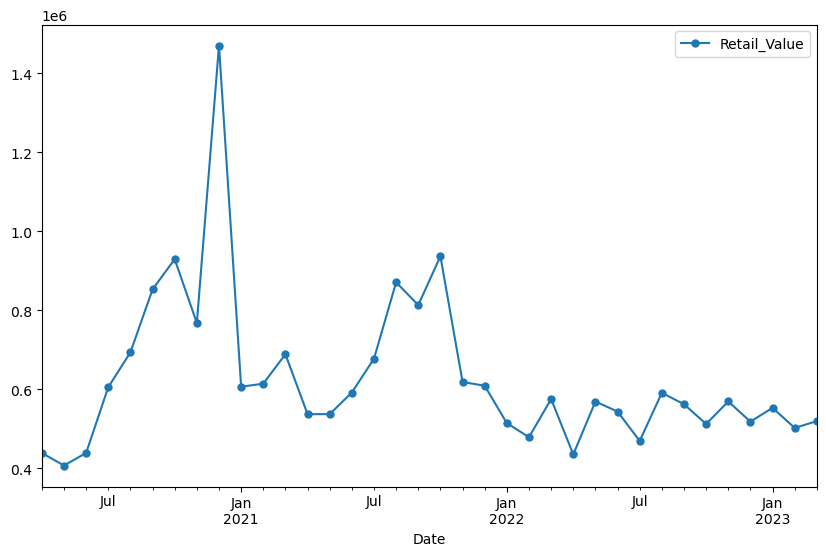

In [11]:
gdf['Retail_Value'].plot(figsize = (10,6), legend=True, marker='o', markersize=5)

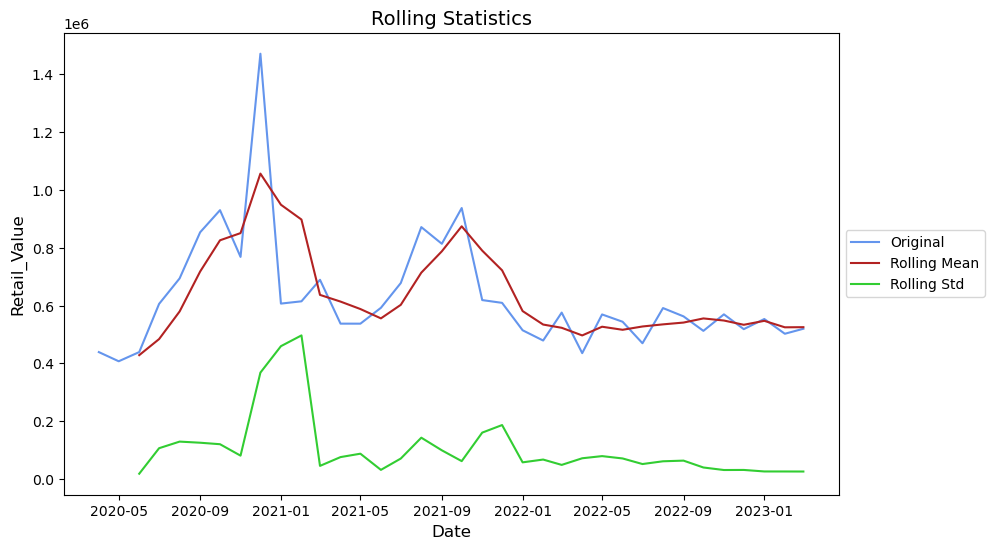

In [12]:
rolling_mean = gdf.rolling(window=3).mean()
rolling_std = gdf.rolling(window=3).std()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gdf, color='cornflowerblue', label='Original')
ax.plot(rolling_mean, color='firebrick', label='Rolling Mean')
ax.plot(rolling_std, color='limegreen', label='Rolling Std')

ax.set_xlabel('Date', size=12)
ax.set_ylabel('Retail_Value', size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Rolling Statistics', size=14)

plt.show()

### Acf (Autocorrelation)

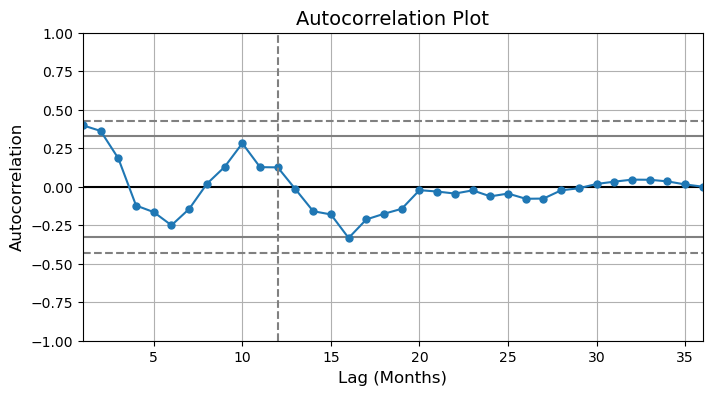

In [13]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

plt.figure(figsize=(8, 4))
pd.plotting.autocorrelation_plot(gdf['Retail_Value'], marker='o', markersize=5)
plt.axvline(x=12, linestyle='--', color='grey')
plt.xlabel('Lag (Months)', fontsize=12)  # explicitly reference the xlabel function from matplotlib.pyplot
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation Plot', fontsize=14)
plt.show()

### Pacf (Partial Autocorrelation)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x400 with 0 Axes>

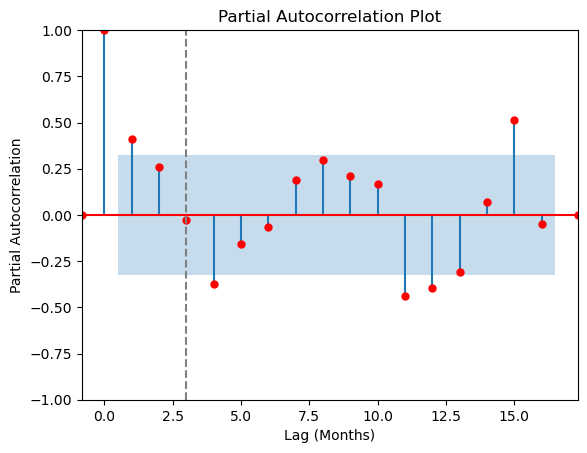

In [14]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
# assume gdf is a pandas DataFrame containing the time series data

plt.figure(figsize=(8, 4))
plot_pacf(gdf['Retail_Value'], lags=16, marker='o', markersize=5, color='red')
plt.axvline(x=3, linestyle='--', color='grey')
plt.xlabel('Lag (Months)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()

### Decomposition

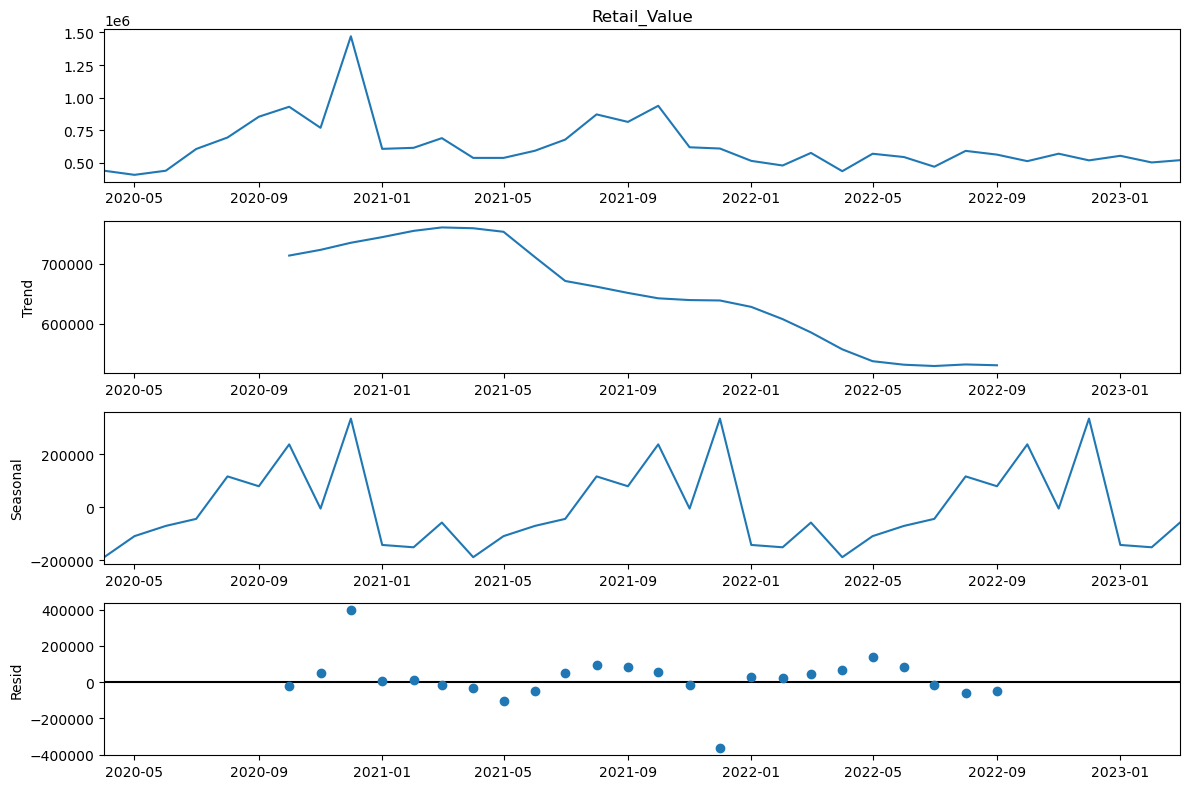

In [15]:
rcParams['figure.figsize'] = 12, 8
dec = seasonal_decompose(gdf["Retail_Value"], model = "add")
dec.plot();

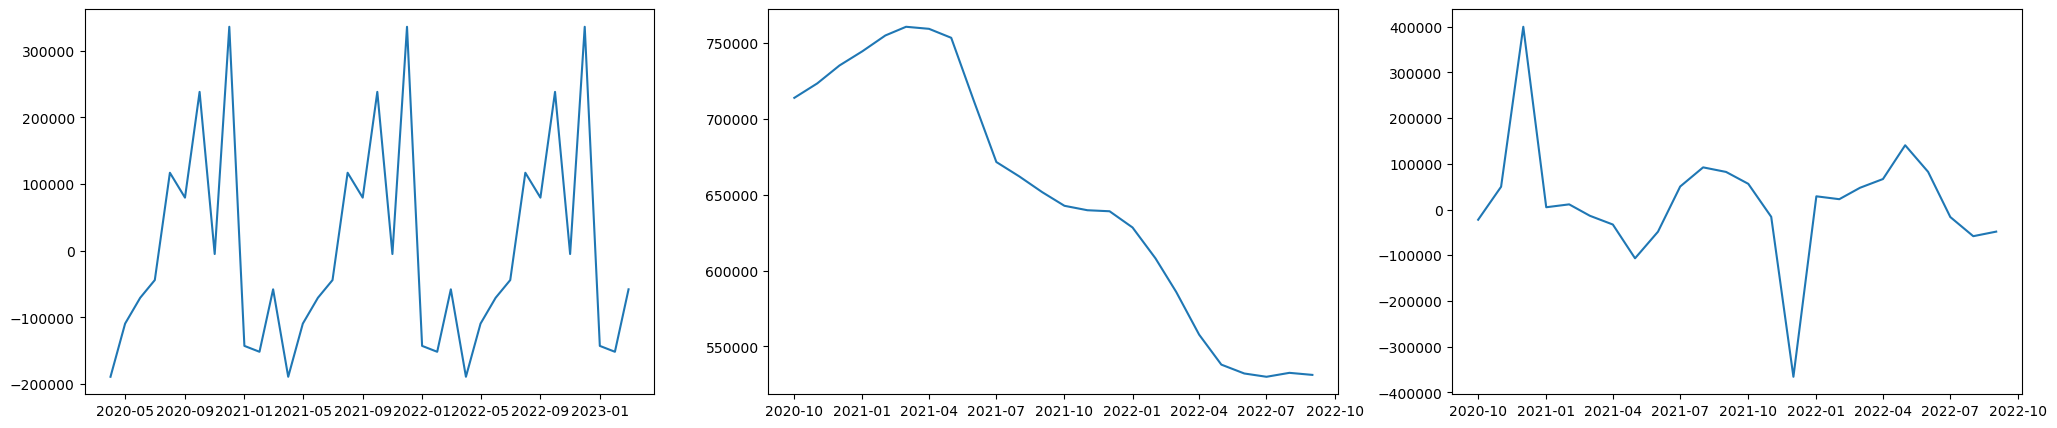

In [16]:
plt.figure(figsize = (25, 5))
a = seasonal_decompose(gdf["Retail_Value"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(dec.seasonal)

plt.subplot(1, 3, 2)
plt.plot(dec.trend)

plt.subplot(1, 3, 3)
plt.plot(dec.resid)

plt.show()

In [17]:
# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(gdf['Retail_Value'])
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: -0.741
p-value: 0.836
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


## Forecasting Model

**ARIMA Model** stands for Auto-Regressive Integrated Moving Average.<br> It is is used for predicting future trends on a time series data. It is model that form of regression analysis.

**Auto-Regressive** models predict future behavior using past behavior where there is some correlation between past and future data.

**Integration** is the difference between present and previous observations. It is used to make the time series stationary.

**Moving Average** is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time

**p**: Value just before convergence in pacf. ( =3 )<br>
**d** : Check whether there is a trend by adf test and visual confirmation of the trend ( =0 )<br>
**q** : value just before convergence in acf ( =1)<br>
**P** : Check how many times the seasonality cycle was repeated in the pacf ( =0 )<br>
**D**: Check whether there is seasonality, 1 or 0 ( =0 ) depending on the need for seasonality difference <br>
**Q**: Check how many times the seasonal cycle based on acf has been repeated (=1)<br>
**m** : seasonal period ( =12 )

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = gdf[:len(gdf)-12]
test_data = gdf[len(gdf)-12:]

arima_model = SARIMAX(gdf['Retail_Value'], order = (3,0,3), seasonal_order = (2,0,0,12))
arima_result = arima_model.fit()
arima_result.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38422D+01    |proj g|=  1.18572D-01

At iterate    5    f=  1.37431D+01    |proj g|=  6.63815D-02

At iterate   10    f=  1.37384D+01    |proj g|=  3.06150D-02

At iterate   15    f=  1.37360D+01    |proj g|=  7.74248D-03

At iterate   20    f=  1.37352D+01    |proj g|=  8.24711D-02

At iterate   25    f=  1.36837D+01    |proj g|=  3.40430D-01

At iterate   30    f=  1.35270D+01    |proj g|=  1.58240D-01

At iterate   35    f=  1.34932D+01    |proj g|=  7.66666D-02

At iterate   40    f=  1.34807D+01    |proj g|=  3.96753D-02

At iterate   45    f=  1.34736D+01    |proj g|=  8.98726D-03

At iterate   50    f=  1.34709D+01    |proj g|=  1.77217D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Retail_Value   No. Observations:                   36
Model:             SARIMAX(3, 0, 3)x(2, 0, [], 12)   Log Likelihood                -484.951
Date:                             Thu, 27 Apr 2023   AIC                            987.902
Time:                                     15:45:19   BIC                           1002.154
Sample:                                 04-01-2020   HQIC                           992.877
                                      - 03-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2203      0.203     10.943      0.000       1.823       2.618
ar.L2         -1.8661      0.309     -6.049      0.000      -2.471      -1.261
ar.L3          0.6458      0.136      4.746      0.000       0.379       0.913
ma.L1         -2.0741      0.227     -9.157      0.000      -2.518      -1.630
ma.L2          2.0721      0.292      7.091      0.000       1.499       2.645
ma.L3         -0.9797      0.180     -5.445      0.000      -1.332      -0.627
ar.S.L12       0.2060      0.144      1.429      0.153      -0.077       0.489
ar.S.L24      -0.0790      0.267     -0.296      0.767      -0.603       0.445
sigma2      1.463e+10   4.09e-11   3.57e+20      0.000    1.46e+10    1.46e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                62.76
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.32e+36. Standard errors may be unstable.
"""

In [64]:
arima_pred = arima_result.predict(start = len(train_data), end = len(gdf)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2022-04-01    580290.923485
2022-05-01    674802.978133
2022-06-01    674680.955470
2022-07-01    610880.562898
2022-08-01    553437.261499
2022-09-01    488664.735575
2022-10-01    573058.703131
2022-11-01    611882.322380
2022-12-01    589650.580140
2023-01-01    620576.952358
2023-02-01    559161.374760
2023-03-01    520261.520853
Freq: MS, Name: ARIMA Predictions, dtype: float64

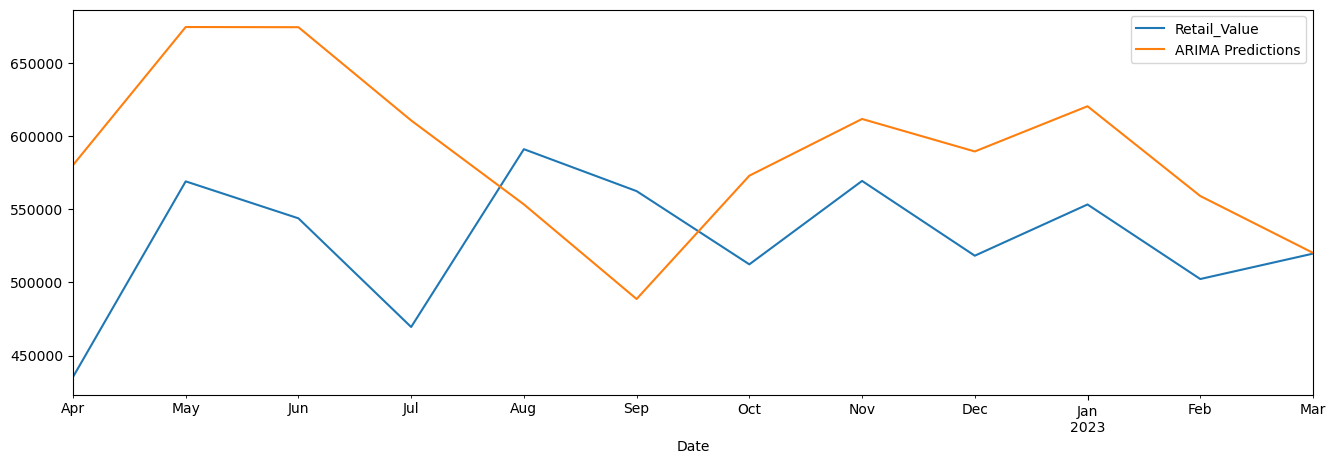

In [65]:
test_data['Retail_Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [66]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['Retail_Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = gdf['Retail_Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 7873312379.168995
RMSE Error: 88731.68757083906
Mean: 628533.1388888889


In [67]:
arima_pred_f = arima_result.predict(start = len(gdf), end = len(gdf)+12, typ="levels").rename("ARIMA Predictions")
arima_pred_f

2023-04-01    484668.772411
2023-05-01    539479.516372
2023-06-01    575352.108188
2023-07-01    591089.079402
2023-08-01    617703.562148
2023-09-01    612423.654028
2023-10-01    576663.600638
2023-11-01    596978.783084
2023-12-01    577041.595434
2024-01-01    590064.513107
2024-02-01    586844.954611
2024-03-01    589342.585500
2024-04-01    598283.942671
Freq: MS, Name: ARIMA Predictions, dtype: float64

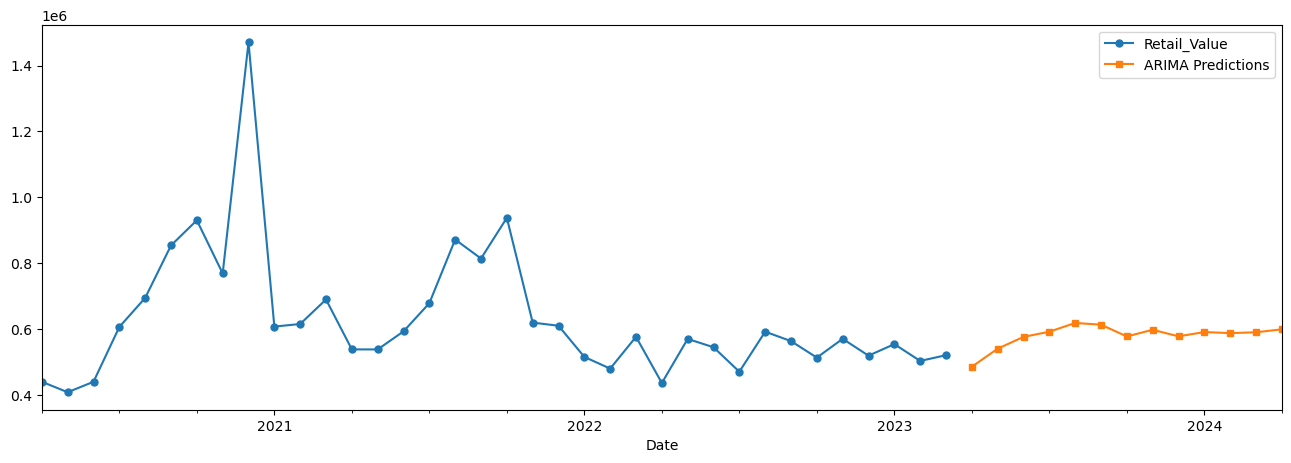

In [68]:
gdf['Retail_Value'].plot(figsize = (16,5), legend=True, marker='o', markersize=5)
arima_pred_f.plot(legend = True, marker='s', markersize=5);

In [69]:
pdf = arima_pred_f.to_frame(name='Retail_Value')
pdf.head()

,Retail_Value
2023-04-01,484668.772411
2023-05-01,539479.516372
2023-06-01,575352.108188
2023-07-01,591089.079402
2023-08-01,617703.562148


In [70]:
udf = pd.concat([gdf, pdf])

udf.reset_index(inplace=True)
udf = udf.rename(columns = {'index':'Date'})

In [71]:
udf.head()

,Date,Retail_Value
0,2020-04-01,438957.0
1,2020-05-01,407218.0
2,2020-06-01,438991.0
3,2020-07-01,605622.0
4,2020-08-01,693806.0


In [72]:
udf.to_csv('/Users/sseyeoni/Documents/jupyter/Cintas/Forecasting/Results/Retail_Predictive_Model_HANDPROT.csv', index=False)